In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential


def generate_images():

    generator = Sequential()

    generator.add(Dense(256*4*4, input_shape = (100,)))
    #generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Reshape((4,4,256)))

    generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))


    generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generator)

model_generator = generate_images()

model_generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         295040    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


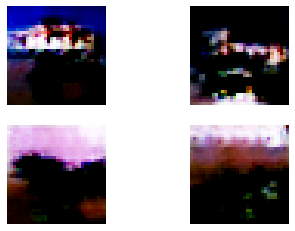

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Definir datos de entrada
def generate_input_data(n_samples):
  X = np.random.randn(100 * n_samples)
  X = X.reshape(n_samples, 100)
  return X

def create_fake_data(model_generator, n_samples):
  input = generate_input_data(n_samples)
  X = model_generator.predict(input)
  y = np.zeros((n_samples, 1))
  return X,y

number_samples = 4
X,_ = create_fake_data(model_generator, number_samples)

# Visualizamos resultados
for i in range(number_samples):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])

In [ ]:
from keras.layers import Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

def image_discriminator():

    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (32,32,3)))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminator)

model_discriminator = image_discriminator()
model_discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 256)        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from keras.datasets import cifar10

def upload_images():
    (Xtrain, Ytrain), (_, _) = cifar10.load_data()

    # Nos quedamos con los perros
    indice = np.where(Ytrain == 0)
    indice = indice[0]
    Xtrain = Xtrain[indice, :,:,:]

    # Normalizamos los datos
    X = Xtrain.astype('float32')
    X = (X - 127.5) / 127.5

    return X

print(upload_images().shape)

(5000, 32, 32, 3)


In [ ]:
import random

def load_real_data(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))
  return X,y

def load_fake_data(n_samples):
  X = np.random.rand(32 * 32 * 3 * n_samples)
  X = -1 + X * 2
  X = X.reshape((n_samples, 32,32,3))
  y = np.zeros((n_samples, 1))
  return X,y

In [ ]:
def entrenar_discriminador(modelo, dataset, n_iteraciones=20, batch = 128):
  medio_batch = int(batch/2)

  for i in range(n_iteraciones):
    X_real, y_real = load_real_data(dataset, medio_batch)
    _, acc_real = modelo.train_on_batch(X_real, y_real)

    X_fake, y_fake = load_fake_data(medio_batch)
    _, acc_fake = modelo.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

#here

In [ ]:
dataset = upload_images()
entrenar_discriminador(model_discriminator, dataset)

In [ ]:
dataset = upload_images()
entrenar_discriminador(model_discriminator, dataset)


1 Real:29.6875, Fake:3.125
2 Real:96.875, Fake:17.1875
3 Real:95.3125, Fake:54.6875
4 Real:79.6875, Fake:87.5
5 Real:71.875, Fake:100.0
6 Real:89.0625, Fake:100.0
7 Real:82.8125, Fake:100.0
8 Real:89.0625, Fake:100.0
9 Real:79.6875, Fake:100.0
10 Real:87.5, Fake:100.0
11 Real:96.875, Fake:100.0
12 Real:96.875, Fake:100.0
13 Real:96.875, Fake:100.0
14 Real:93.75, Fake:100.0
15 Real:100.0, Fake:100.0
16 Real:100.0, Fake:100.0
17 Real:100.0, Fake:100.0
18 Real:100.0, Fake:100.0
19 Real:96.875, Fake:100.0
20 Real:100.0, Fake:100.0


In [ ]:
def crear_gan(discriminator, generator):
    discriminator.trainable=False
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)

    opt = Adam(lr=0.0002,beta_1=0.5) 
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

gan = crear_gan(model_discriminator,model_generator)
gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         1007363   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 522497    
Total params: 1,529,860
Trainable params: 1,007,363
Non-trainable params: 522,497
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

def mostrar_imagenes_generadas(datos_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # Hacemos que los datos vayan de 0 a 1
  datos_fake = (datos_fake + 1) / 2.0

  for i in range(10):
    plt.imshow(datos_fake[i])
    plt.axis('off')
    nombre = str(epoch) + '_imagen_generada_' + str(i) + '.png'
    plt.savefig(nombre, bbox_inches='tight')
    plt.close()

In [ ]:
def evaluar_y_guardar(model_generator, epoch, medio_dataset):

  # We save the model
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre = str(epoch) + '_' + str(now)+"_model_generator_" + '.h5'
  model_generator.save(nombre)

  # We generate new data
  X_real,Y_real = load_real_data(dataset, medio_dataset)
  X_fake, Y_fake =  create_fake_data(model_generator,medio_dataset)

  # We evaluate the model
  _, acc_real = model_discriminator.evaluate(X_real, Y_real)
  _, acc_fake = model_discriminator.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [ ]:
def entrenamiento(datos, model_generator, model_discriminator, epochs, n_batch, inicio = 0):
  dimension_batch = int(datos.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # We iterate over the epochs
  for epoch in range(inicio, inicio + epochs):
    # We iterate over all batches
    for batch in range(n_batch):

      # We load all the real data
      X_real,Y_real = load_real_data(dataset, medio_dataset)


      # We train the discriminator withEnrenamos discriminador con datos reales
      coste_discriminador_real, _ = model_discriminator.train_on_batch(X_real, Y_real)
      X_fake, Y_fake =  create_fake_data(model_generator,medio_dataset)

      coste_discriminador_fake, _ = model_discriminator.train_on_batch(X_fake, Y_fake)

      # We generate input images for the GAN
      X_gan = generate_input_data(medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # We train the GAN with fake data
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    # Every 10 epochs we show the results and cost 
    if (epoch+1) % 10 == 0:
      evaluar_y_guardar(model_generator,epoch = epoch, medio_dataset= medio_dataset)
      mostrar_imagenes_generadas(X_fake, epoch = epoch)

In [ ]:
entrenamiento(dataset, model_generator, model_discriminator, epochs = 300, n_batch=128, inicio = 0)

2/2 [==============================] - 0s 11ms/step - loss: 0.7269 - accuracy: 0.4062
Acc Real:60.9375% Acc Fake:40.625%
2/2 [==============================] - 0s 9ms/step - loss: 0.5870 - accuracy: 0.7656
Acc Real:59.375% Acc Fake:76.5625%
2/2 [==============================] - 0s 12ms/step - loss: 0.5102 - accuracy: 0.8125
Acc Real:62.5% Acc Fake:81.25%
2/2 [==============================] - 0s 8ms/step - loss: 0.4794 - accuracy: 0.8594
Acc Real:68.75% Acc Fake:85.9375%
2/2 [==============================] - 0s 8ms/step - loss: 0.4560 - accuracy: 0.9062
Acc Real:89.0625% Acc Fake:90.625%
2/2 [==============================] - 0s 9ms/step - loss: 0.4270 - accuracy: 0.9062
Acc Real:76.5625% Acc Fake:90.625%
2/2 [==============================] - 0s 11ms/step - loss: 0.3966 - accuracy: 0.9062
Acc Real:78.125% Acc Fake:90.625%
2/2 [==============================] - 0s 9ms/step - loss: 0.3361 - accuracy: 0.9375
Acc Real:81.25% Acc Fake:93.75%
2/2 [==============================] - 0s 8ms/

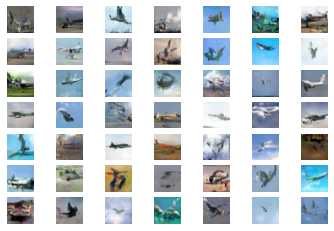

In [ ]:
X_fake, _ = create_fake_data(n_samples=49, model_generator=model_generator)
X_fake = (X_fake+1)/2

for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])